# VCGC: Vertex Coloring with Grover's Circuit 
Rudimentary Curcuit To Run Grover's Search Algorithm for a vertex coloring instance on the AER simulator and IBM's Quantum Computer. 

1. Prepare the circuit and add the uniform state preparation operator.

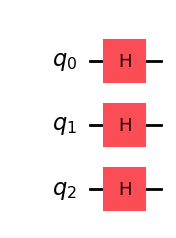

In [2]:
from qiskit import *
import matplotlib.pyplot as plt
import numpy as np  

# Create a Quantum Circuit acting on a quantum register of 5 qubits
qc = QuantumCircuit(5,5)

# Subcircuit for uniform state preparation operator
spo = QuantumCircuit(3,name="state_prep")

# Add a H gate on all qubits except the last one
# This will give the superposition of all the qubits except the last one
for qubit in range(3):
    spo.h(qubit)
qc.x(3)
qc.h(3)
qc.barrier()

# qc.decompose(gates_to_decompose="state_prep").draw('mpl')
spo.draw('mpl')

2. Manually creating the oracle circuit for evaulating the scaled down vertex coloring problem shown below

![Simple Vertex Coloring problem](vertex_coloring_instance.png)

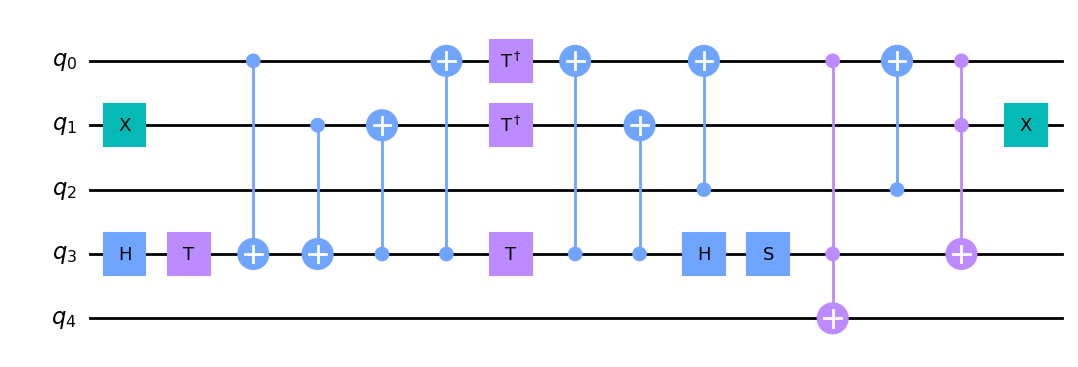

In [3]:

# Create a quantum subcircuit for grover oracle
grover_oracle = QuantumCircuit(5, name="grover_oracle")
grover_oracle.x(1)

# Toffoli gate 1 (Start)
grover_oracle.h(3)
grover_oracle.t(3)
grover_oracle.cx(0,3)
grover_oracle.cx(1,3)
grover_oracle.cx(3,1)
grover_oracle.cx(3,0)
grover_oracle.tdg(0)
grover_oracle.tdg(1)
grover_oracle.t(3)
grover_oracle.cx(3,0)
grover_oracle.cx(3,1)
grover_oracle.h(3)
grover_oracle.s(3)
# Toffoli gate 1 (End)

grover_oracle.cx(2,0)

grover_oracle.ccx(0,3,4)
# Toffoli gate 2 (Start)
# grover_oracle.t(0)
# grover_oracle.t(3)
# grover_oracle.h(4)
# grover_oracle.cx(3,0)
# grover_oracle.t(4)
# grover_oracle.cx(4,3)
# grover_oracle.cx(0,4)
# grover_oracle.tdg(3)
# grover_oracle.cx(0,3)
# grover_oracle.tdg(0)
# grover_oracle.tdg(3)
# grover_oracle.t(4)
# grover_oracle.cx(4,3)
# grover_oracle.cx(0,4)
# grover_oracle.h(4)
# grover_oracle.cx(3,0)
# Toffoli gate 2 (End)

grover_oracle.cx(2,0)

grover_oracle.ccx(0,1,3)
# Toffoli gate 3 (Start)
# grover_oracle.t(0)
# grover_oracle.t(1)
# grover_oracle.h(3)
# grover_oracle.cx(1,0)
# grover_oracle.t(3)
# grover_oracle.cx(3,1)
# grover_oracle.cx(0,3)
# grover_oracle.tdg(1)
# grover_oracle.cx(0,1)
# grover_oracle.tdg(0)
# grover_oracle.tdg(1)
# grover_oracle.t(3)
# grover_oracle.cx(3,1)
# grover_oracle.cx(0,3)
# grover_oracle.h(3)
# grover_oracle.cx(1,0)
# grover_oracle.h(3)
# grover_oracle.measure(3,0)
# grover_oracle.ccz(3,1,0)
# grover_oracle.x(3)
# Toffoli gate 3 (End)

grover_oracle.x(1)

grover_oracle.draw('mpl',style='clifford')


/home/mael/Desktop/vcgc/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/latex.py:154: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /home/mael/Desktop/vcgc/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, _ = load_style(style)


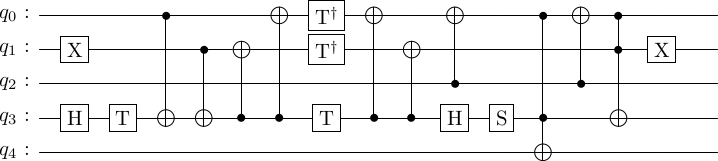

In [4]:
grover_oracle.draw('latex',style='iqx')

3. Defining the diffusion operator

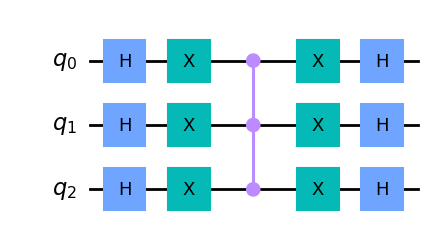

In [5]:
# Create a quantum subcircuit for grover diffusion operator
grover_diffusion = QuantumCircuit(3, name="grover_diffusion")
grover_diffusion.h([0,1,2])
grover_diffusion.x([0,1,2])
grover_diffusion.ccz(0,1,2)
grover_diffusion.x([0,1,2])
grover_diffusion.h([0,1,2])

grover_diffusion.draw('mpl',style='clifford')

4. Connect the whole circuit together together for the first iteration

In [ ]:
# from qiskit.circuit.classicalfunction import classical_function
# from qiskit.circuit.classicalfunction.types import Int1
 
# @classical_function
# def grover_oracle(a: Int1, b: Int1, c: Int1) -> Int1:
#     return (a and not b and ( c ^ a))
 
# grover_oracle_synth = grover_oracle.synth(registerless=True)
# grover_oracle_synth.decompose().draw('mpl')

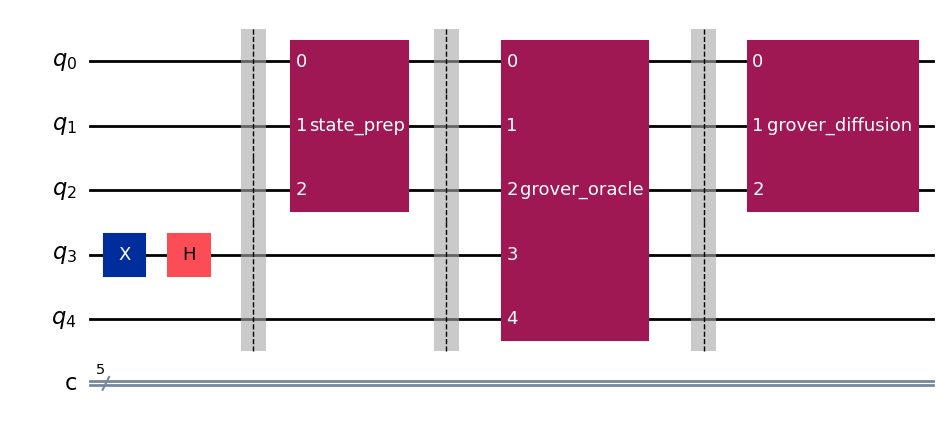

In [6]:
# Combining the subcircuits to form the complete Grover's algorithm
qc.append(spo, [0, 1, 2])
qc.barrier()
qc.append(grover_oracle, [0,1,2,3,4])
qc.barrier()
qc.append(grover_diffusion, [0,1,2])
# qc.barrier()
# qc.append(grover_oracle, [0,1,2,3,4])
# qc.barrier()
# qc.append(grover_diffusion, [0,1,2])


qc.draw('mpl')

5. Add measurements and running the circuit of the AER simulator

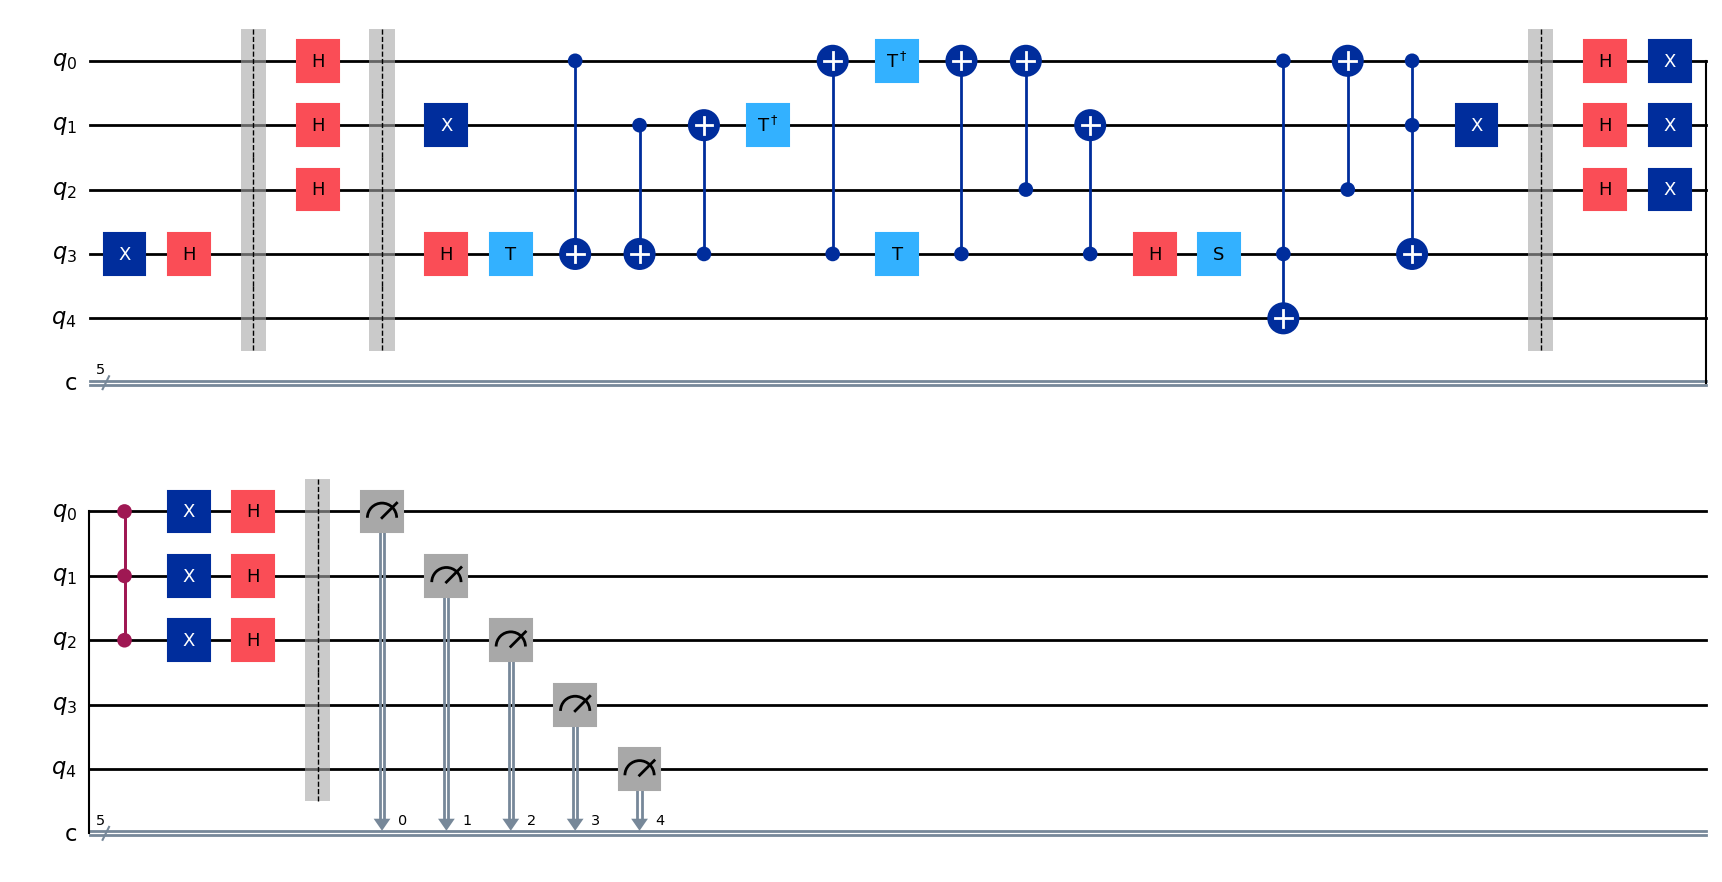

In [7]:

# qc.measure([0, 1, 2], [0, 1, 2]) # Measure the first 3 qubits
qc.measure_all(add_bits=False)
qc_decomposed : QuantumCircuit = qc.decompose(gates_to_decompose=["state_prep", "grover_oracle", "grover_diffusion"])
qc_decomposed.draw('mpl')


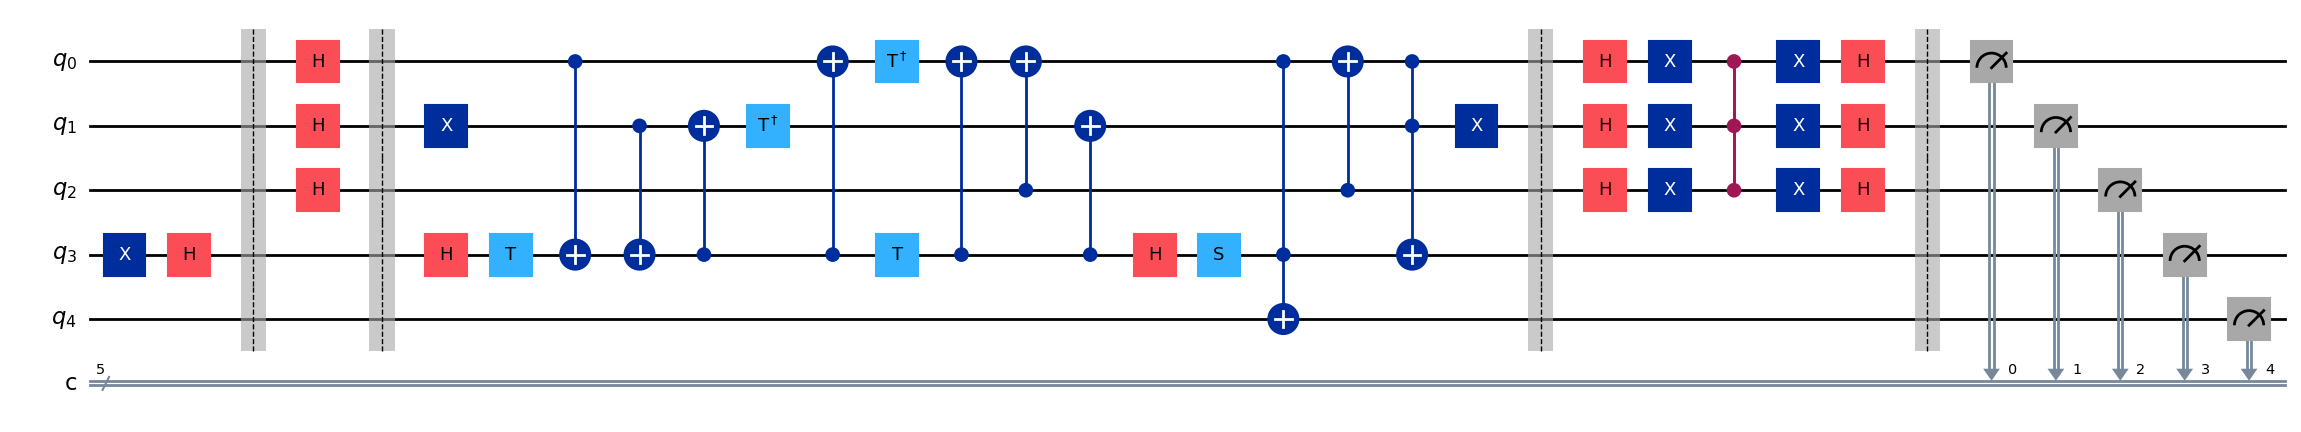

In [8]:
qc_decomposed.draw('mpl',fold=-1)

{'000': 48, '001': 238, '010': 237, '011': 121, '100': 98, '101': 55, '110': 187, '111': 40}


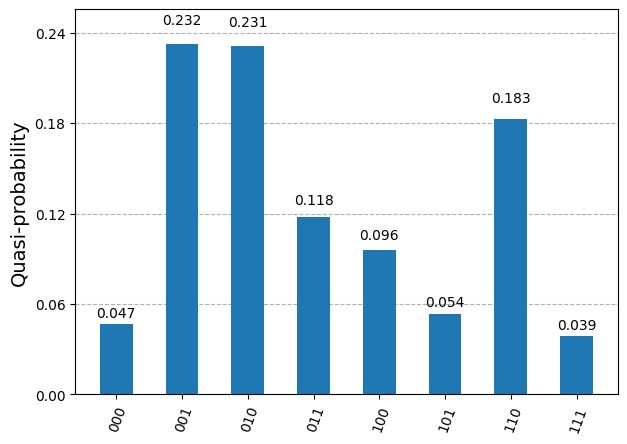

In [67]:
from qiskit_aer import Aer
# import basic plot tools
from qiskit.visualization import plot_histogram, plot_distribution

# Creating the backend
qasm_sim = Aer.get_backend('qasm_simulator')
result = qasm_sim.run(qc_decomposed).result()
counts = result.get_counts()

# A function to extract the counts of the useful qubits
def process_counts(counts, num_qubits=3):
    # New dictionary to store our results in.
    new_counts = {f'{i:0{num_qubits}b}': 0 for i in range(2**num_qubits)}

    # Loop through the counts dictionary, adding the value to the 
    # respective key in new_counts based on what state the show_qubit is in
    for count in counts:
        count_idx = (len(count) - num_qubits)
        new_counts[count[count_idx:count_idx+num_qubits]] += counts[count]
    
    return new_counts

# Use the function to process the counts
new_counts = process_counts(counts)
print(new_counts)
plot_distribution(new_counts)

# plot_histogram(counts)

6. Running on a real device

In [15]:

# # Run our circuit on the least busy backend. Transpiling before running.
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# service = QiskitRuntimeService()

# backend = service.least_busy(simulator=False, operational=True)

# target = backend.target
# pm = generate_preset_pass_manager(target=target, optimization_level=0)

# circuit_isa = pm.run(qc)
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")


In [16]:
# # Print the transpiled circuit depth 
# print(circuit_isa.depth())

# Dynamic Decoupling Circuit (JB's code)
This code snippet demonstrates the use of dynamic decoupling to mitigate decoherence in quantum circuits. The `PassManager` is configured with the `ALAPScheduleAnalysis` and `PadDynamicalDecoupling` passes to apply dynamic decoupling sequences to the circuit. The optimized circuits are then transpiled and their depths are printed.

In [24]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library import XGate
from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis, PadDynamicalDecoupling, DynamicCircuitInstructionDurations
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)
target = backend.target
durations = DynamicCircuitInstructionDurations.from_backend(backend=backend)


optimized_pm = generate_preset_pass_manager(target=target, optimization_level=3)
dd_rep = 8
dd_sequence = [XGate()] * dd_rep

optimized_pm.scheduling = PassManager([
    ALAPScheduleAnalysis(durations=durations),
    PadDynamicalDecoupling(
        durations=durations,
        dd_sequences=dd_sequence,
        pulse_alignment=16
    )
])
NUM_TRIAL = 20
transpiled_circuits = []
for i in range(NUM_TRIAL):
    transpiled_circuits.append(optimized_pm.run(qc))


depths = [circuit.depth() for circuit in transpiled_circuits]
print(depths)

[154, 154, 154, 154, 219, 149, 149, 149, 154, 154, 149, 154, 149, 149, 149, 149, 154, 154, 149, 154]


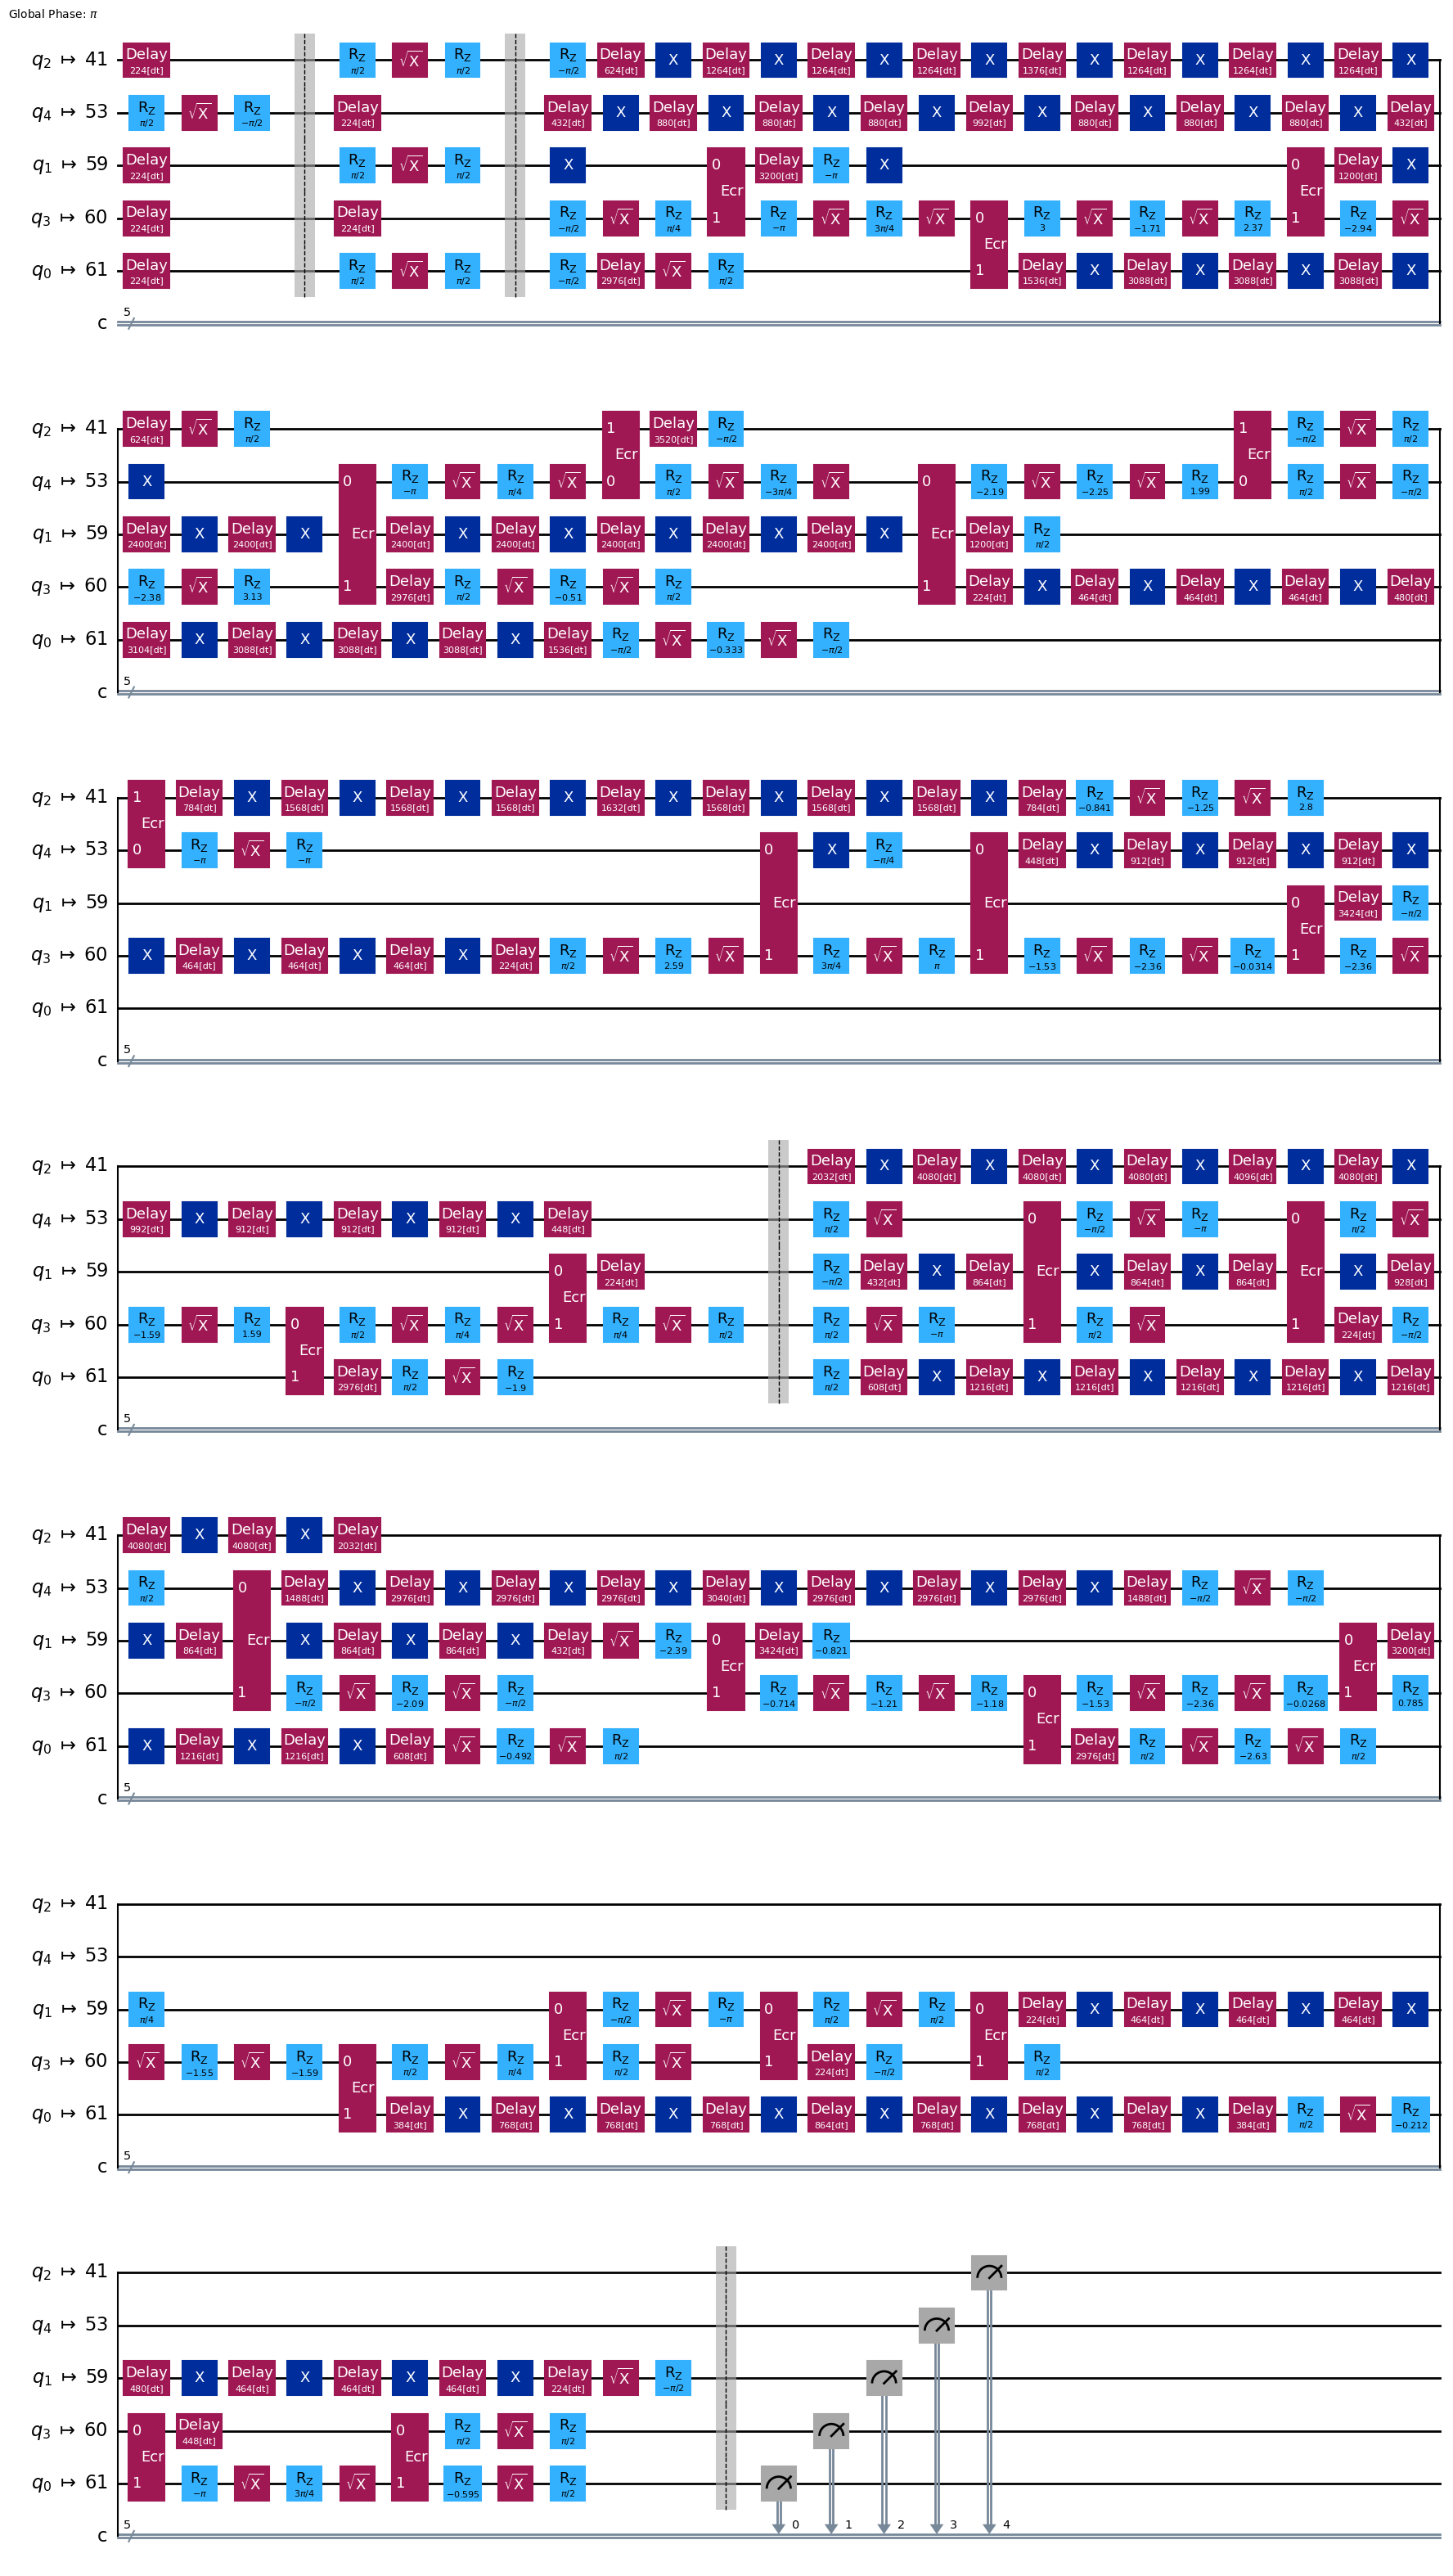

In [25]:
# Draw the circuit
transpiled_circuit = transpiled_circuits[1]
transpiled_circuit.draw('mpl', idle_wires=False,
                        )

In [82]:
# Listing the qubits used in the transpiled circuit
used_qubits = transpiled_circuit.layout.final_index_layout()
used_qubits

[60, 59, 61, 53, 41]

In [83]:
print(transpiled_circuit.depth())

308


In [84]:
import mthree
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(used_qubits)
# mit.apply_correction(transpiled_circuit)


[RunningManJob<job_id='cyvp80gy2gd000889vsg', backend_name='ibm_kyiv', executor='NA'>]

In [85]:
# Running the transpiled circuit using the sampler
from qiskit_ibm_runtime import Sampler
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
job = sampler.run([transpiled_circuit])

{'000': 735, '001': 3539, '010': 918, '011': 1338, '100': 832, '101': 693, '110': 798, '111': 1147}


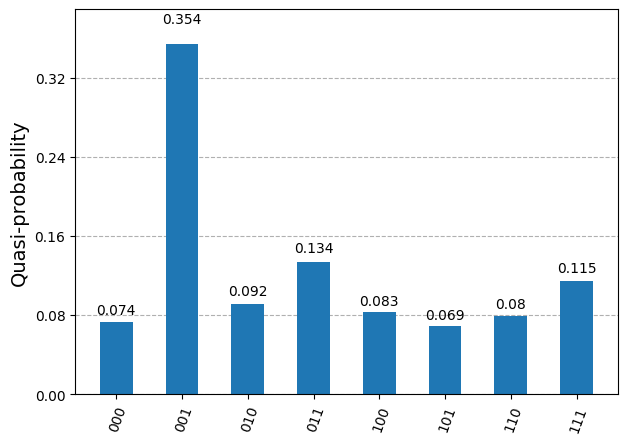

In [86]:
from qiskit.visualization import plot_distribution
result = job.result()
# result = service.job('cyvnd7m4raf0008epag0').result()
# Job with prob 0.432: cyvnd7m4raf0008epag0
# The above job has an optimized Toffoli gate applied to it

# Job with prob 0.336: cydx70c9b62g008jh290
# The above job has the original qiskit Toffoli gate applied to it
raw_counts = result[0].data.c.get_counts()
new_raw_counts = process_counts(raw_counts)
print(new_raw_counts)
plot_distribution(new_raw_counts)

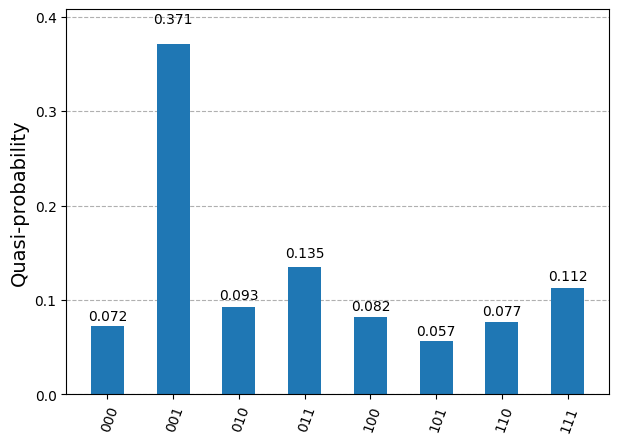

In [88]:
# Applying the mitigation
quasi = mit.apply_correction(raw_counts, [60, 59, 61, 53, 41])

mitigated_counts = {k: int(v*10_000) for k, v in quasi.items()}
new_mitigated_counts = process_counts(mitigated_counts)
plot_distribution(new_mitigated_counts)